# Import functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


from sklearn.feature_selection import mutual_info_regression

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.append('../../nn_physical_concepts')

from scinet import *
import scinet.ed_oscillator as edo

# Load data

In [2]:
import pandas as pd

df = pd.read_csv('../data/transient_data_ch41step.csv')


In [3]:
df_rates = pd.read_csv('../data/constant_data_ch41step.csv')


In [276]:
kf = np.zeros((1,1001))
for i in range(1001):
    kf[0,i] = float(df_rates['kf'][i][1:-1])

In [279]:
kf = kf[0]

# Helper functions

In [370]:
def my_load_traindata(df,thalf = 1.25e-5):
    mydf = df[df['t [s]'] <=thalf]
    in1 = np.zeros((2001*25,25))
    in2 = np.zeros((2001*25,1))
    out = np.zeros((2001*25,1))
    for j in range(25):
        for i in range(1000,3001):
            in1[(i-1000)*25 + j,:] = mydf[mydf['T [K]']==i]['Yco2']
    in2[:,0] = mydf['t [s]']
    out[:,0] = mydf['Yco2']
    return [in1, in2, out]

def my_load_traindata_3(df,thalf = 1.25e-5):
    mydf = df[df['t [s]'] <=thalf]
    in1 = np.zeros((2001*25,25))
    in2 = np.zeros((2001*25,3))
    out = np.zeros((2001*25,1))
    for j in range(25):
        for i in range(1000,3001):
            in1[(i-1000)*25 + j,:] = mydf[mydf['T [K]']==i]['Yco2']
    in2[:,0] = mydf['t [s]']
    in2[:,1] = mydf['Yo2']
    in2[:,2] = mydf['Ych4']
    out[:,0] = mydf['Yco2']
    return [in1, in2, out]

def my_load_testdata(df,T,thalf = 1.25e-5 ):
    mydf = df[df['t [s]'] <= thalf]
    in1 = np.zeros((51,25))
    in2 = np.zeros((51,1))
    for i in range(51): 
        in1[i,:] = mydf[mydf['T [K]']==T]['Yco2']
        in2[i,0] = i*5e-7
    out = in2
    return [in1,in2,out]

def my_load_testdata3(df,T,thalf = 1.25e-5 ):
    mydf = df[df['t [s]'] <= thalf]
    in1 = np.zeros((51,25))
    in2 = np.zeros((51,3))
    for i in range(51): 
        in1[i,:] = mydf[mydf['T [K]']==T]['Yco2']
        in2[i,0] = i*5e-7
    in2[:,1] = df[df['T [K]']==T]['Yo2']
    in2[:,2] = df[df['T [K]']==T]['Ych4']
    out = np.zeros((51,1))
    return [in1,in2,out]

def my_load_testdata_singletime(df,T,time,thalf = 1.25e-5 ):
    mydf = df[df['t [s]'] <= thalf]
    in1 = np.zeros((1,25))
    in2 = np.zeros((1,3))
    in1[0,:] = mydf[mydf['T [K]']==T]['Yco2']
    in2[0,0] = time
    in2[:,1] = df[(df['T [K]']==T) & (df['t [s]']<(time+4e-7))& (df['t [s]']>(time-4e-7))]['Yo2']
    in2[:,2] = df[(df['T [K]']==T) & (df['t [s]']<(time+4e-7))& (df['t [s]']>(time-4e-7))]['Ych4']
    out = np.zeros((1,1))
    return [in1,in2,out]

from sklearn.model_selection import train_test_split

def my_train_test_split(train_data3,test_size = 0.25,random_state=42):
    in1train, in1test = train_test_split(train_data3[0], test_size=test_size, random_state=random_state)
    in2train, in2test = train_test_split(train_data3[1], test_size=test_size, random_state=random_state)
    outtrain, outtest = train_test_split(train_data3[2], test_size=test_size, random_state=random_state)
    return [in1train,in2train,outtrain],[in1test,in2test,outtest]



# Train and predict

In [374]:
train_data3  = my_load_traindata_3(df,thalf = 1.25e-5)

In [375]:
train_data, valid_data  = my_train_test_split(train_data3)

In [376]:
net = nn.Network(latent_size = 3,input_size =  25,input2_size = 3,output_size = 1,encoder_num_units= [500, 100],)
net.train(training_data = train_data, validation_data = valid_data,epoch_num = 100, batch_size =  128, learning_rate = 1e-3,test_step=None)

  0%|          | 0/100 [00:00<?, ?it/s]

In [377]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times'],'size' : 16})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

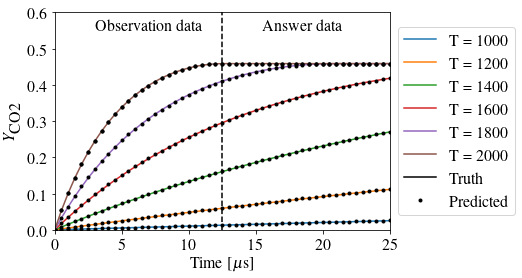

In [378]:
t = np.arange(51)*5e-1 #mus
T = 1000
plt.plot([12.5,12.5],[0,0.6],'k--')
for T in range(1000,2001,200): 
    test_data = my_load_testdata3(df,T)
    a_precicted = net.run(test_data, net.output).ravel()
    plt.plot(t,a_precicted,label = r'T = '+str(T))

    plt.plot(t,df[df['T [K]']==T]['Yco2'],'k.',label='_nolegend_')

plt.plot([-1],[-1],'k',label ='Truth')

plt.plot(t,df[df['T [K]']==T]['Yco2'],'k.',label='Predicted')

plt.legend(loc='center right',bbox_to_anchor = (1.4,0.5))
plt.xlim((0,25))
plt.ylim((0,0.6))
plt.text(3,0.55,'Observation data')
plt.text(15.5,0.55,'Answer data')
plt.ylabel(r'$Y_{\textrm{CO2}}$')
plt.xlabel(r'Time [$\mu$s]')
plt.savefig('chem_prediction.png',dpi=400,bbox_inches='tight')

In [379]:
latentspace = np.zeros((101,3))
time = 1.5e-5
for T in range(1000,3001,30):
    latentspace[(T-1000)/30,:] = np.array([net.run(my_load_testdata_singletime(df,T,time), net.mu)[0] ])

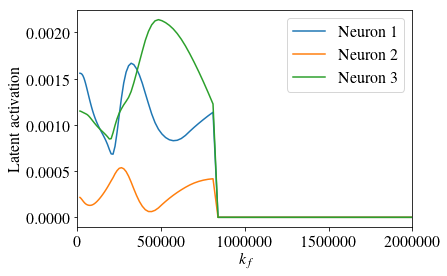

In [380]:
plt.plot(kf[0:1001:10],latentspace[:,0],label = 'Neuron 1')
plt.plot(kf[0:1001:10],latentspace[:,1],label ='Neuron 2')
plt.plot(kf[0:1001:10],latentspace[:,2],label = 'Neuron 3')
plt.ylabel('Latent activation')
plt.legend()
plt.xlabel(r'$k_f$')
plt.xlim([0,2e6])
plt.xticks([0,5e5,1e6,1.5e6,2e6])
plt.savefig('chem_latent.png',dpi=400,bbox_inches='tight')